## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt
from tqdm import tqdm
from TCGame_Env1 import TicTacToe

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

C:\Users\Namrata Thakur\anaconda3\envs\python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [5]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
max_epsilon = 1.0
min_epsilon = 0.001

def epsilon_decay(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*time)
    z = np.random.random()
    if z > epsilon:
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)
    else:
        agent_actions, env_actions = env.action_space(state)
        action = random.choice(list(agent_actions))
    return action




#### Tracking the state-action pairs for checking convergence - write your code here

In [6]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)
print(len(Q_dict))
print(len(States_track))

0
0


In [7]:
Q_dict

defaultdict(dict, {})

In [8]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [('x-x-x-x-x-x-x-x-x',(6,5)),('x-x-x-x-x-x-x-x-x',(1,9)),
                   ('x-3-x-x-1-x-x-x-x',(7,5)),('x-5-x-x-x-x-5-7-x',(8,2))]
    for q_value in sample_q_values:
        state = q_value[0]
        action = q_value[1]
        States_track[state][action] = []  

In [9]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [10]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [11]:
initialise_tracking_states()

In [12]:
States_track

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(6, 5): [], (1, 9): []},
             'x-3-x-x-1-x-x-x-x': {(7, 5): []},
             'x-5-x-x-x-x-5-7-x': {(8, 2): []}})

#### Define hyperparameters  ---write your code here

In [13]:
EPISODES = 5000000
# EPISODES = 20000

LR = 0.01   # learning rate
GAMMA = 0.91

threshold = 20000      
policy_threshold = 30000

### Q-update loop ---write your code here

In [14]:
start_time = time.time()

for episode in tqdm(range(EPISODES)):
    ##### Start writing your code from the next line
    env = TicTacToe()
    curr_state = env.state
    isTerminated = False
    add_to_dict(curr_state)
    total_reward = 0

    while not isTerminated:
        current_state_string = Q_state(curr_state)
        curr_action = epsilon_decay(curr_state, episode)
        next_state, reward, isTerminated = env.step(curr_state, curr_action)

        next_state_string = Q_state(next_state)
        add_to_dict(next_state)

        if isTerminated:
            Q_dict[current_state_string][curr_action] += LR * (
                (reward - Q_dict[current_state_string][curr_action]))
        else:
            max_next = max(Q_dict[next_state_string],
                           key=Q_dict[next_state_string].get)
            Q_dict[current_state_string][curr_action] += LR * (
                (reward + (GAMMA * (Q_dict[next_state_string][max_next]))) -
                Q_dict[current_state_string][curr_action])

        curr_state = next_state
        total_reward += reward


    # Tracking the Q-Values here
    
    if (episode == threshold-1):        #at the 19999th episode
        initialise_tracking_states()

    if ((episode+1) % threshold) == 0:   #every 20000th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')

    # Saving the Policy here
    
    if ((episode+1)% policy_threshold ) == 0:  #every 30000th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')
    
    
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

100%|████████████████████████████████████████████████████████████████████| 5000000/5000000 [1:02:19<00:00, 1337.15it/s]


#### Check the Q-dictionary

In [15]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -0.8864767427695738,
              (0, 3): -1.3462233489174427,
              (0, 5): -0.9589193094661468,
              (0, 7): -1.3191794009859514,
              (0, 9): -1.3333682611310855,
              (1, 1): 0.24402687444635984,
              (1, 3): -1.2799583905918943,
              (1, 5): 0.4741827493862454,
              (1, 7): -1.2498808145209637,
              (1, 9): -1.2575138180701835,
              (2, 1): -1.253322308210147,
              (2, 3): -1.3227341536623014,
              (2, 5): -1.3873090970947415,
              (2, 7): -1.319613999492791,
              (2, 9): 5.478643480580107,
              (3, 1): -1.3169455634810887,
              (3, 3): -1.3024998472339575,
              (3, 5): -1.2828680536738652,
              (3, 7): -1.2824008330201693,
              (3, 9): -1.3225537286813334,
              (4, 1): -1.3425251321916996,
              (4, 3): -1.3772794520172658,
              (4, 5)

In [16]:
len(Q_dict)

2267407

In [17]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
random_state_key= np.random.choice(list(Q_dict.keys()))
random_state_key

'5-x-2-3-7-8-x-x-6'

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [18]:
States_track['x-3-x-x-1-x-x-x-x'].keys()

dict_keys([(7, 5)])

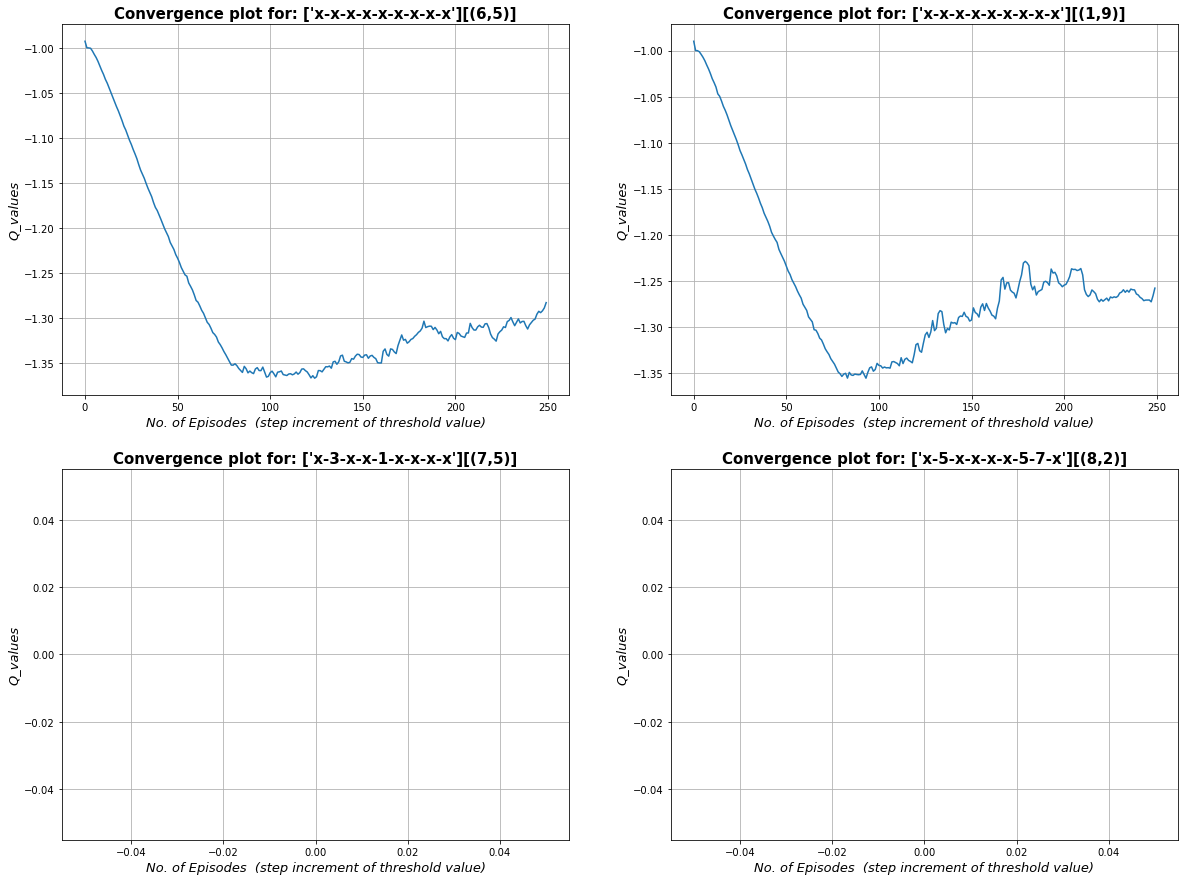

In [19]:
# Write the code for plotting the graphs for state-action pairs tracked
plt.figure(0, figsize=(20,15))

#Graph 1: Convergence Plot for state-action pair: ['x-x-x-x-x-x-x-x-x'][(6,5)]
x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(6,5)])))
plt.subplot(221)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(6,5)]))
plt.title("Convergence plot for: ['x-x-x-x-x-x-x-x-x'][(6,5)]", fontsize=15, fontweight='bold')
plt.ylabel("Q_values", fontsize=13, fontstyle='italic')
plt.xlabel("No. of Episodes  (step increment of threshold value)", fontsize=13, fontstyle='italic')
plt.grid(True)

#Graph 2: Convergence Plot for state-action pair: ['x-x-9-x-x-6-x-x-x'][(7,7)]
x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(1,9)])))
plt.subplot(222)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(1,9)]))
plt.title("Convergence plot for: ['x-x-x-x-x-x-x-x-x'][(1,9)]", fontsize=15, fontweight='bold')
plt.ylabel("Q_values", fontsize=13, fontstyle='italic')
plt.xlabel("No. of Episodes  (step increment of threshold value)", fontsize=13, fontstyle='italic')
plt.grid(True)

#Graph 3: Convergence Plot for state-action pair: ['x-1-6-x-x-x-x-x-x'][(0,9)]
x_axis = np.asarray(range(0, len(States_track['x-3-x-x-1-x-x-x-x'][(7,5)])))
plt.subplot(223)
plt.plot(x_axis,np.asarray(States_track['x-3-x-x-1-x-x-x-x'][(7,5)]))
plt.title("Convergence plot for: ['x-3-x-x-1-x-x-x-x'][(7,5)]", fontsize=15, fontweight='bold')
plt.ylabel("Q_values", fontsize=13, fontstyle='italic')
plt.xlabel("No. of Episodes  (step increment of threshold value)", fontsize=13, fontstyle='italic')
plt.grid(True)

#Graph 4: Convergence Plot for state-action pair: ['x-1-x-x-x-x-2-x-x'][(2,3)]
x_axis = np.asarray(range(0, len(States_track['x-5-x-x-x-x-5-7-x'][(8,2)])))
plt.subplot(224)
plt.plot(x_axis,np.asarray(States_track['x-5-x-x-x-x-5-7-x'][(8,2)]))
plt.title("Convergence plot for: ['x-5-x-x-x-x-5-7-x'][(8,2)]", fontsize=15, fontweight='bold')
plt.ylabel("Q_values", fontsize=13, fontstyle='italic')
plt.xlabel("No. of Episodes  (step increment of threshold value)", fontsize=13, fontstyle='italic')
plt.grid(True)


### Epsilon - decay check

In [20]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

C:\Users\Namrata Thakur\anaconda3\envs\python39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


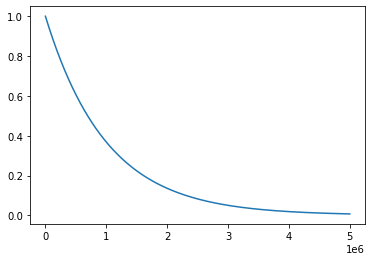

In [22]:
plt.plot(time, epsilon)
plt.show()